In [57]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns
#import gcsfs
import cftime
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
chicago_LAT=41.88
chicago_LON=(360-87.6298)%360

In [15]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [16]:
# 2. Search for maximum temperature for July 30
expts = ['ssp370','historical']

cat = col.search(
    experiment_id=expts,
    table_id='day',
    variable_id='tasmax',
    #grid_label='gn'
)

query = dict(
    experiment_id=expts,
    table_id='day',
    variable_id=['tasmax'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id","member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-CM2,2,1,1,1
AWI-CM-1-1-MR,2,1,1,1
BCC-ESM1,2,1,1,1
CMCC-ESM2,2,1,1,1
CanESM5,2,1,1,1
EC-Earth3,2,1,1,1
EC-Earth3-AerChem,2,1,1,1
EC-Earth3-Veg-LR,2,1,1,1
FGOALS-g3,2,1,1,1


In [17]:
df = col_subset.df
model_counts = df.groupby('source_id').size()
print(model_counts)

source_id
ACCESS-CM2           2
AWI-CM-1-1-MR        2
BCC-ESM1             2
CMCC-ESM2            2
CanESM5              2
EC-Earth3            2
EC-Earth3-AerChem    2
EC-Earth3-Veg-LR     2
FGOALS-g3            2
GFDL-ESM4            2
INM-CM4-8            2
INM-CM5-0            2
IPSL-CM6A-LR         2
KACE-1-0-G           2
MIROC6               2
MPI-ESM-1-2-HAM      2
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR        2
MRI-ESM2-0           2
NorESM2-LM           2
NorESM2-MM           2
dtype: int64


In [18]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [19]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 2.17 s, sys: 344 ms, total: 2.52 s
Wall time: 6.21 s


In [20]:
def extract_july30_data(ds, chicago_lat=41.88, chicago_lon=(360-87.6298)%360, buffer=0):
    """
    Extract data for July 30 from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset
    - chicago_lat (float, optional): Latitude for Chicago. Default is 41.88.
    - chicago_lon (float, optional): Longitude for Chicago. Default is -87.63.
    - buffer (float, optional): Buffer for spatial slice around Chicago. Default is 0.5.

    Returns:
    - xarray.Dataset: Dataset subsetted for July 30 and the specified space and time range.
    """

    
    # Filter by time and space
    subset = ds.sel(
        time=((ds['time.year'] >= 1850) & (ds['time.year'] <= 1879)) | 
              ((ds['time.year'] >= 2071) & (ds['time.year'] <= 2100)),
        lat=chicago_lat,
        lon=chicago_lon,method='nearest'
    )
    
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        subset_july30_condition = subset.time.dt.dayofyear == 211
    elif isinstance(ds['time'].values[0], cftime.datetime):
        subset_july30_condition = [date for date in subset['time'].values if (date.month == 7) and (date.day == 30)]
    else:
        raise ValueError("Unknown datetime type in the dataset.")


    # Extract July 30 data
    subset_july30 = subset.sel(time=subset_july30_condition)
    #####subset_july30 = subset

    return subset_july30

In [21]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

#Initialize an Empty Dictionary for Aligned Datasets:
dsets_aligned = {}

#Iterate Over dsets_ Dictionary:
for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year
        ds.coords['day']  = ds.time.dt.dayofyear
        ##print(ds['lat'])
    
    dsets_jul30_chicago = [v[expt].pipe(extract_july30_data)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                      for expt in expts]

    # align everything 
    dsets_aligned[k] = xr.concat(dsets_jul30_chicago, join='outer',
                                 dim=expt_da)

  0%|          | 0/21 [00:00<?, ?it/s]

In [22]:
with progress.ProgressBar():
    dsets_aligned_ = dask.compute(dsets_aligned)[0]

[########################################] | 100% Completed | 10m 28s


In [23]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

final_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

final_ds

<xarray.Dataset>
Dimensions:        (year: 60, experiment_id: 2, source_id: 21, bnds: 2)
Coordinates:
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * experiment_id  (experiment_id) <U10 'ssp370' 'historical'
  * bnds           (bnds) float64 1.0 2.0
  * source_id      (source_id) <U17 'ACCESS-CM2' ... 'NorESM2-MM'
Data variables:
    tasmax         (source_id, experiment_id, year) float32 nan nan ... nan nan
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP AerChemMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/4f1ca5a2-ebe9-48a7-91d3-23625c2e2d56...
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    version:                v20191108
    netcdf_tracking_ids:    hdl:21.14100/4f1ca5a2-ebe9-48a7-91d3-23625c2e2d56...
    version_id:             v20191108

In [53]:
#Select data for specific location to plot
df_loc = final_ds.to_dataframe().reset_index()
df_eoc = final_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).to_dataframe().reset_index()
df_pi  = final_ds.sel(experiment_id='historical').sel(year= slice(1850,1879)).to_dataframe().reset_index()
df_loc

,year,experiment_id,source_id,bnds,tasmax
0,1850,ssp370,ACCESS-CM2,1.0,NaN
1,1850,ssp370,ACCESS-CM2,2.0,NaN
2,1850,ssp370,AWI-CM-1-1-MR,1.0,NaN
3,1850,ssp370,AWI-CM-1-1-MR,2.0,NaN
4,1850,ssp370,BCC-ESM1,1.0,NaN
...,...,...,...,...,...
5035,2100,historical,MRI-ESM2-0,2.0,NaN
5036,2100,historical,NorESM2-LM,1.0,NaN
5037,2100,historical,NorESM2-LM,2.0,NaN
5038,2100,historical,NorESM2-MM,1.0,NaN


In [28]:
df_pi = df_pi.dropna()
df_pi

,year,source_id,bnds,experiment_id,tasmax
0,1850,ACCESS-CM2,1.0,historical,297.739258
1,1850,ACCESS-CM2,2.0,historical,297.739258
2,1850,AWI-CM-1-1-MR,1.0,historical,300.636688
3,1850,AWI-CM-1-1-MR,2.0,historical,300.636688
4,1850,BCC-ESM1,1.0,historical,298.149841
...,...,...,...,...,...
1255,1879,MRI-ESM2-0,2.0,historical,304.267395
1256,1879,NorESM2-LM,1.0,historical,301.549835
1257,1879,NorESM2-LM,2.0,historical,301.549835
1258,1879,NorESM2-MM,1.0,historical,309.594879


In [33]:
df_eoc = df_eoc.dropna()
df_eoc

,year,source_id,bnds,experiment_id,tasmax
0,2071,ACCESS-CM2,1.0,ssp370,317.533203
1,2071,ACCESS-CM2,2.0,ssp370,317.533203
2,2071,AWI-CM-1-1-MR,1.0,ssp370,311.295441
3,2071,AWI-CM-1-1-MR,2.0,ssp370,311.295441
6,2071,CMCC-ESM2,1.0,ssp370,305.555176
...,...,...,...,...,...
1255,2100,MRI-ESM2-0,2.0,ssp370,302.175446
1256,2100,NorESM2-LM,1.0,ssp370,306.731842
1257,2100,NorESM2-LM,2.0,ssp370,306.731842
1258,2100,NorESM2-MM,1.0,ssp370,309.159485


In [52]:
df_loc = df_loc.dropna()
df_loc

,year,experiment_id,source_id,bnds,tasmax
42,1850,historical,ACCESS-CM2,1.0,297.739258
43,1850,historical,ACCESS-CM2,2.0,297.739258
44,1850,historical,AWI-CM-1-1-MR,1.0,300.636688
45,1850,historical,AWI-CM-1-1-MR,2.0,300.636688
46,1850,historical,BCC-ESM1,1.0,298.149841
...,...,...,...,...,...
4993,2100,ssp370,MRI-ESM2-0,2.0,302.175446
4994,2100,ssp370,NorESM2-LM,1.0,306.731842
4995,2100,ssp370,NorESM2-LM,2.0,306.731842
4996,2100,ssp370,NorESM2-MM,1.0,309.159485


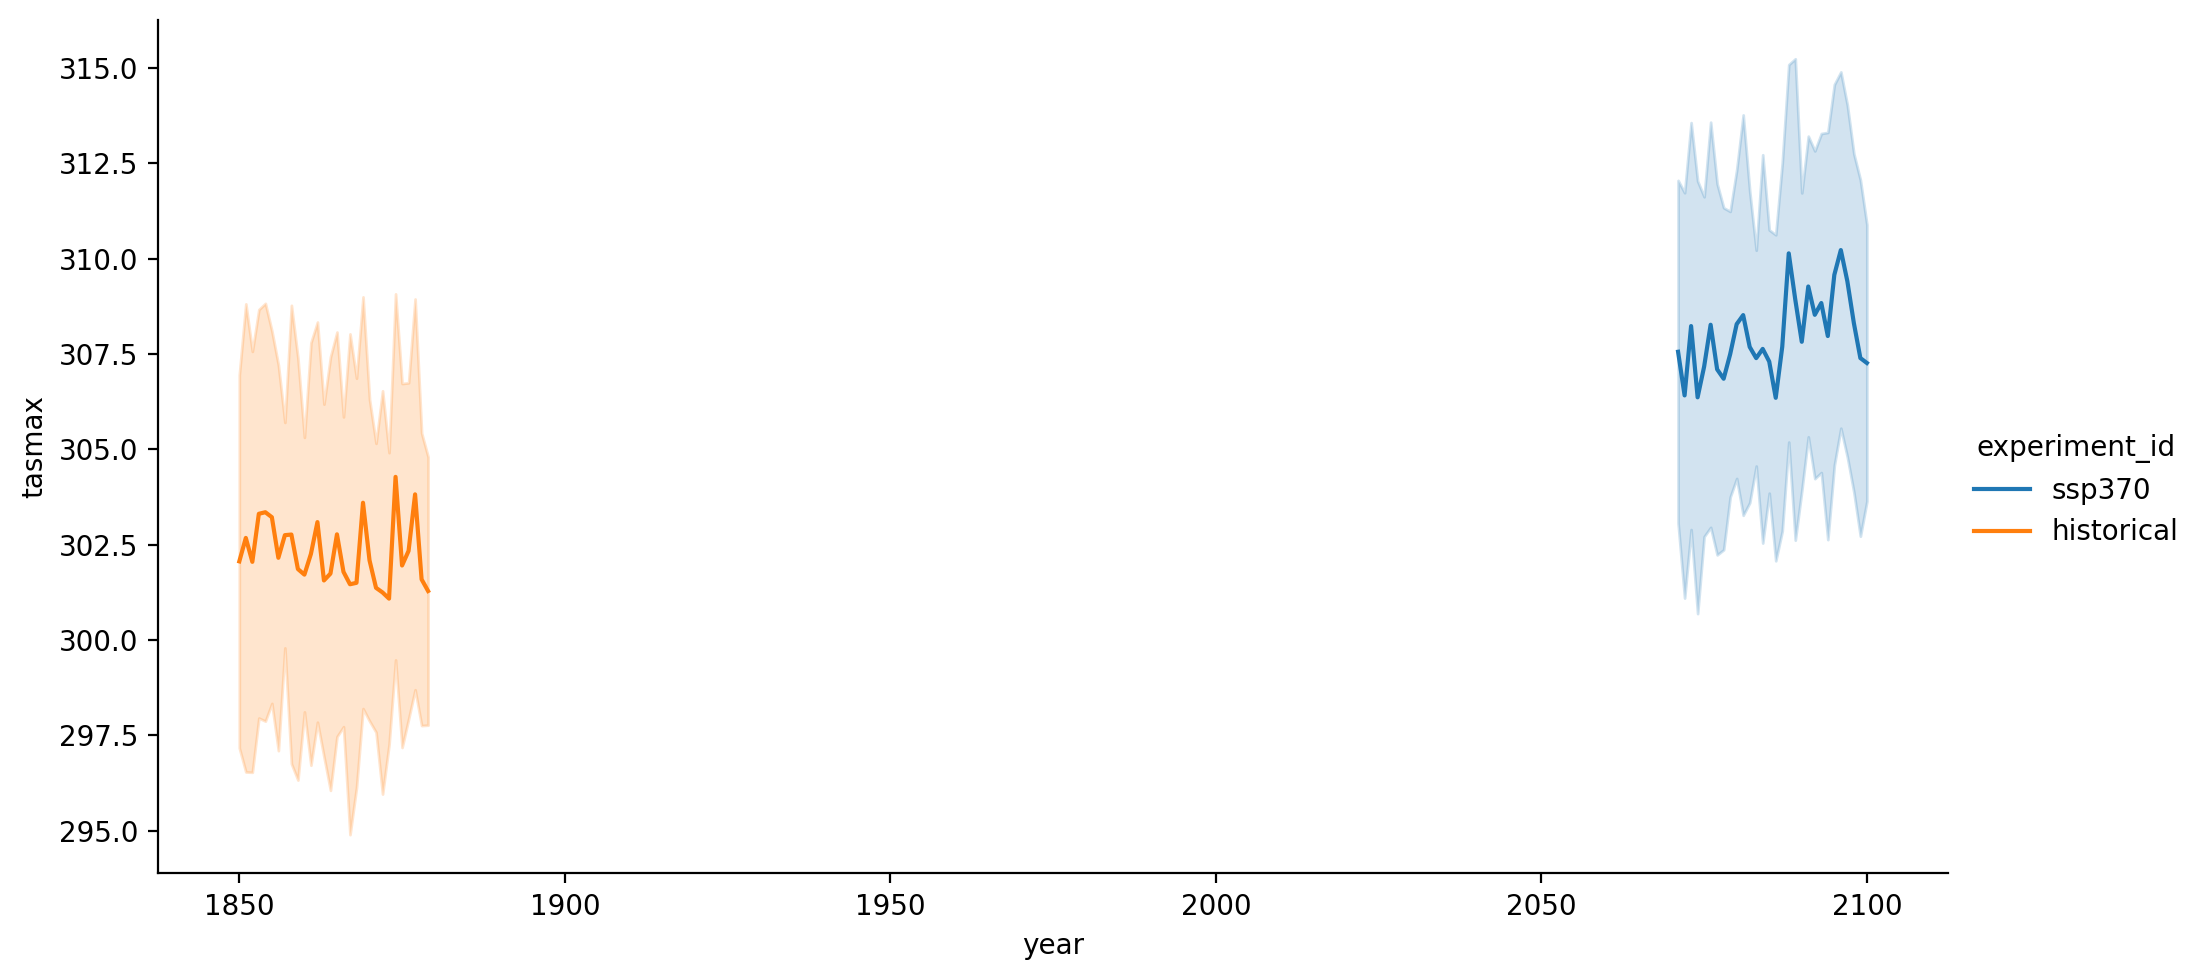

In [54]:
sns.relplot(data=df_loc,x="year", y="tasmax", hue='experiment_id',
            kind="line", errorbar="sd", aspect=2);

In [38]:
quantiles = np.linspace(0,1.0,30)
quantiles

array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])

In [48]:
df_eoc_quants                  = df_eoc.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
df_eoc_quants.columns          = ['source_id','quantiles','tasmax']
df_eoc_quants['experiment_id'] = 'ssp370'
df_eoc_quants

,source_id,quantiles,tasmax,experiment_id
0,ACCESS-CM2,0.000000,302.318115,ssp370
1,ACCESS-CM2,0.034483,302.533447,ssp370
2,ACCESS-CM2,0.068966,302.625732,ssp370
3,ACCESS-CM2,0.103448,305.045166,ssp370
4,ACCESS-CM2,0.137931,305.705078,ssp370
...,...,...,...,...
565,NorESM2-MM,0.862069,314.588593,ssp370
566,NorESM2-MM,0.896552,315.282471,ssp370
567,NorESM2-MM,0.931034,315.438629,ssp370
568,NorESM2-MM,0.965517,315.642670,ssp370


In [55]:
df_pi_quants                  = df_pi.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
df_pi_quants.columns          = ['source_id','quantiles','tasmax']
df_pi_quants['experiment_id'] = 'historical'
df_pi_quants

,source_id,quantiles,tasmax,experiment_id
0,ACCESS-CM2,0.000000,295.197510,historical
1,ACCESS-CM2,0.034483,295.982910,historical
2,ACCESS-CM2,0.068966,296.375977,historical
3,ACCESS-CM2,0.103448,297.168213,historical
4,ACCESS-CM2,0.137931,297.739258,historical
...,...,...,...,...
625,NorESM2-MM,0.862069,310.514435,historical
626,NorESM2-MM,0.896552,310.521576,historical
627,NorESM2-MM,0.931034,310.573761,historical
628,NorESM2-MM,0.965517,312.378235,historical


In [59]:
df_quants = pd.concat([df_eoc_quants, df_pi_quants],ignore_index=True)
df_quants 

,source_id,quantiles,tasmax,experiment_id
0,ACCESS-CM2,0.000000,302.318115,ssp370
1,ACCESS-CM2,0.034483,302.533447,ssp370
2,ACCESS-CM2,0.068966,302.625732,ssp370
3,ACCESS-CM2,0.103448,305.045166,ssp370
4,ACCESS-CM2,0.137931,305.705078,ssp370
...,...,...,...,...
1195,NorESM2-MM,0.862069,310.514435,historical
1196,NorESM2-MM,0.896552,310.521576,historical
1197,NorESM2-MM,0.931034,310.573761,historical
1198,NorESM2-MM,0.965517,312.378235,historical


Text(0.5, 0.98, 'July 30, EOC tasmax at Chicago: 21 CMIP6 models')

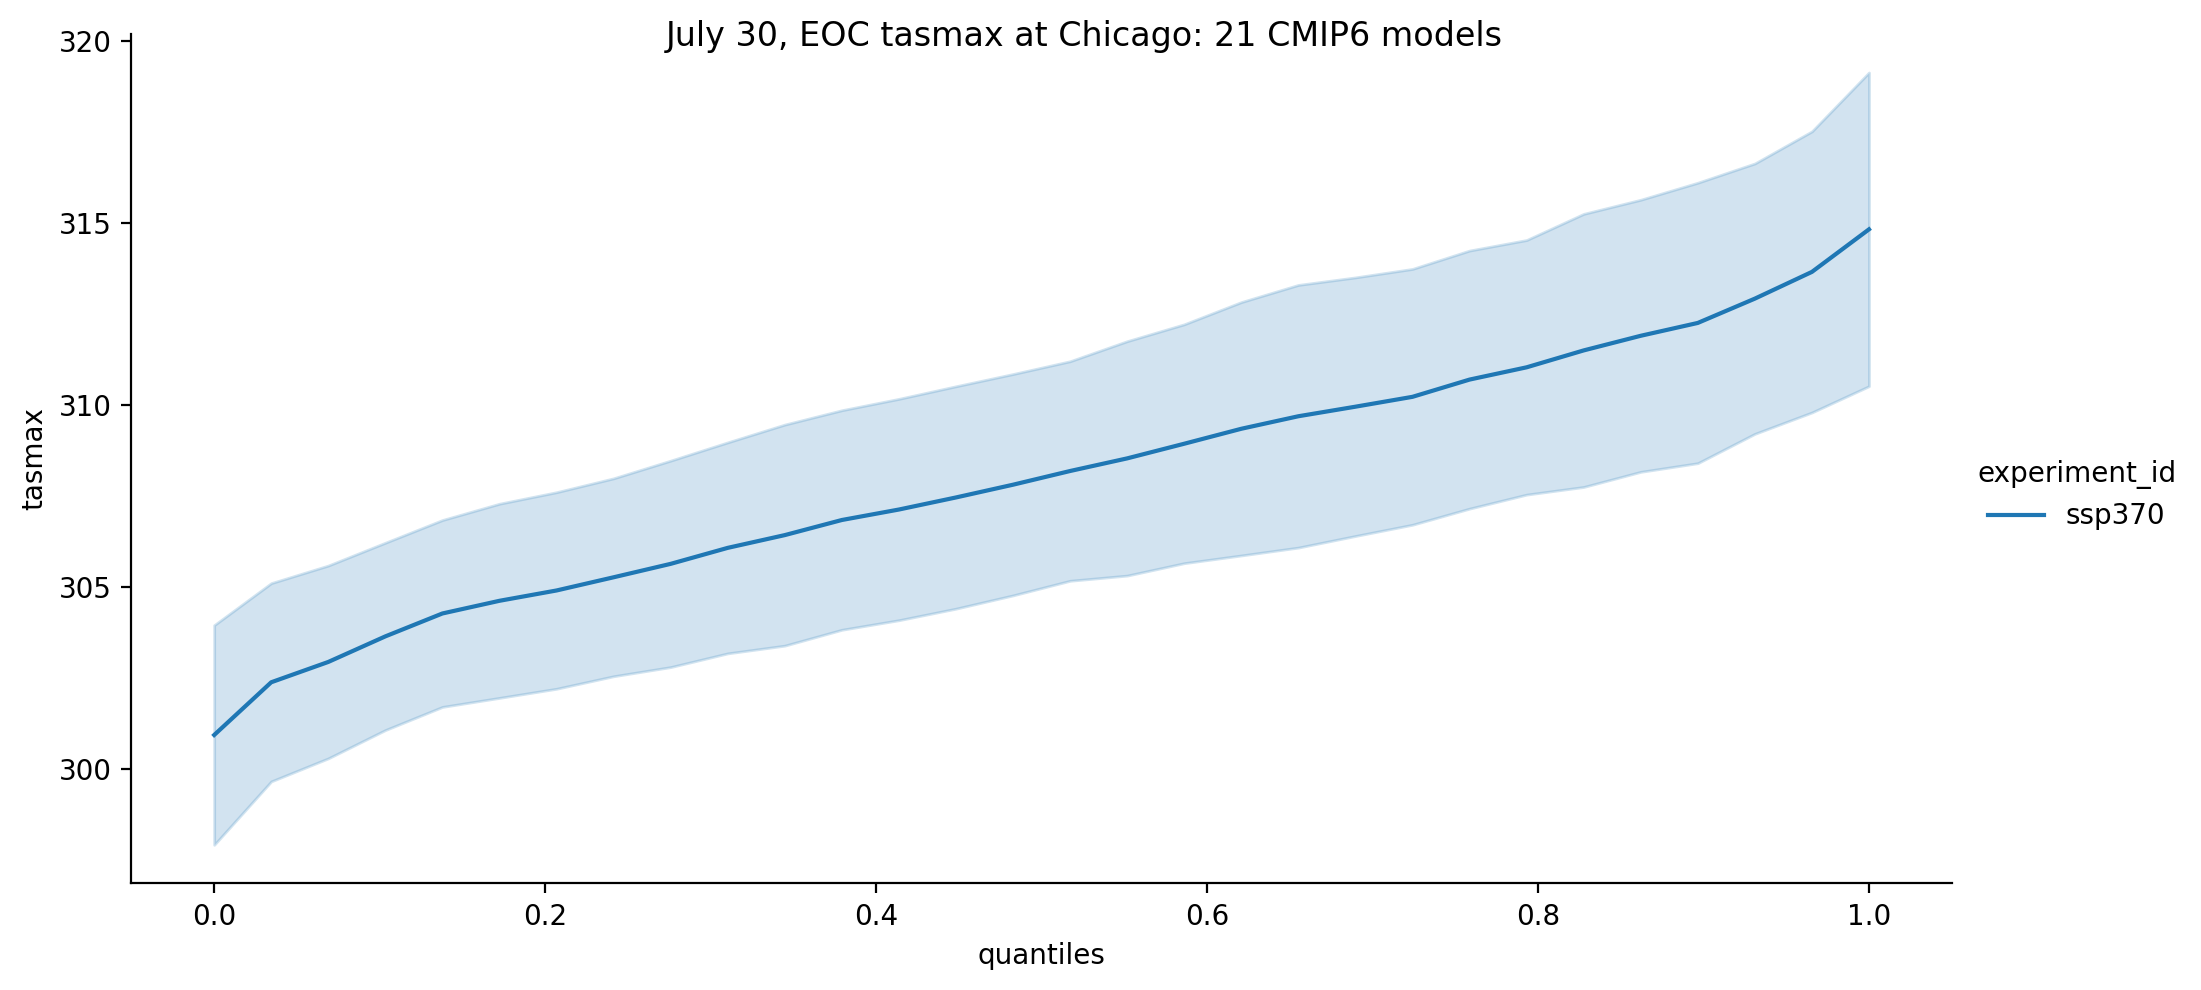

In [60]:
g = sns.relplot(data=df_eoc_quants,x="quantiles", y="tasmax",hue='experiment_id',
            kind="line", errorbar="sd", aspect=2);
g.fig.suptitle('July 30, EOC tasmax at Chicago: 21 CMIP6 models')

Text(0.5, 0.98, 'July 30, tasmax at Chicago: 21 CMIP6 models')

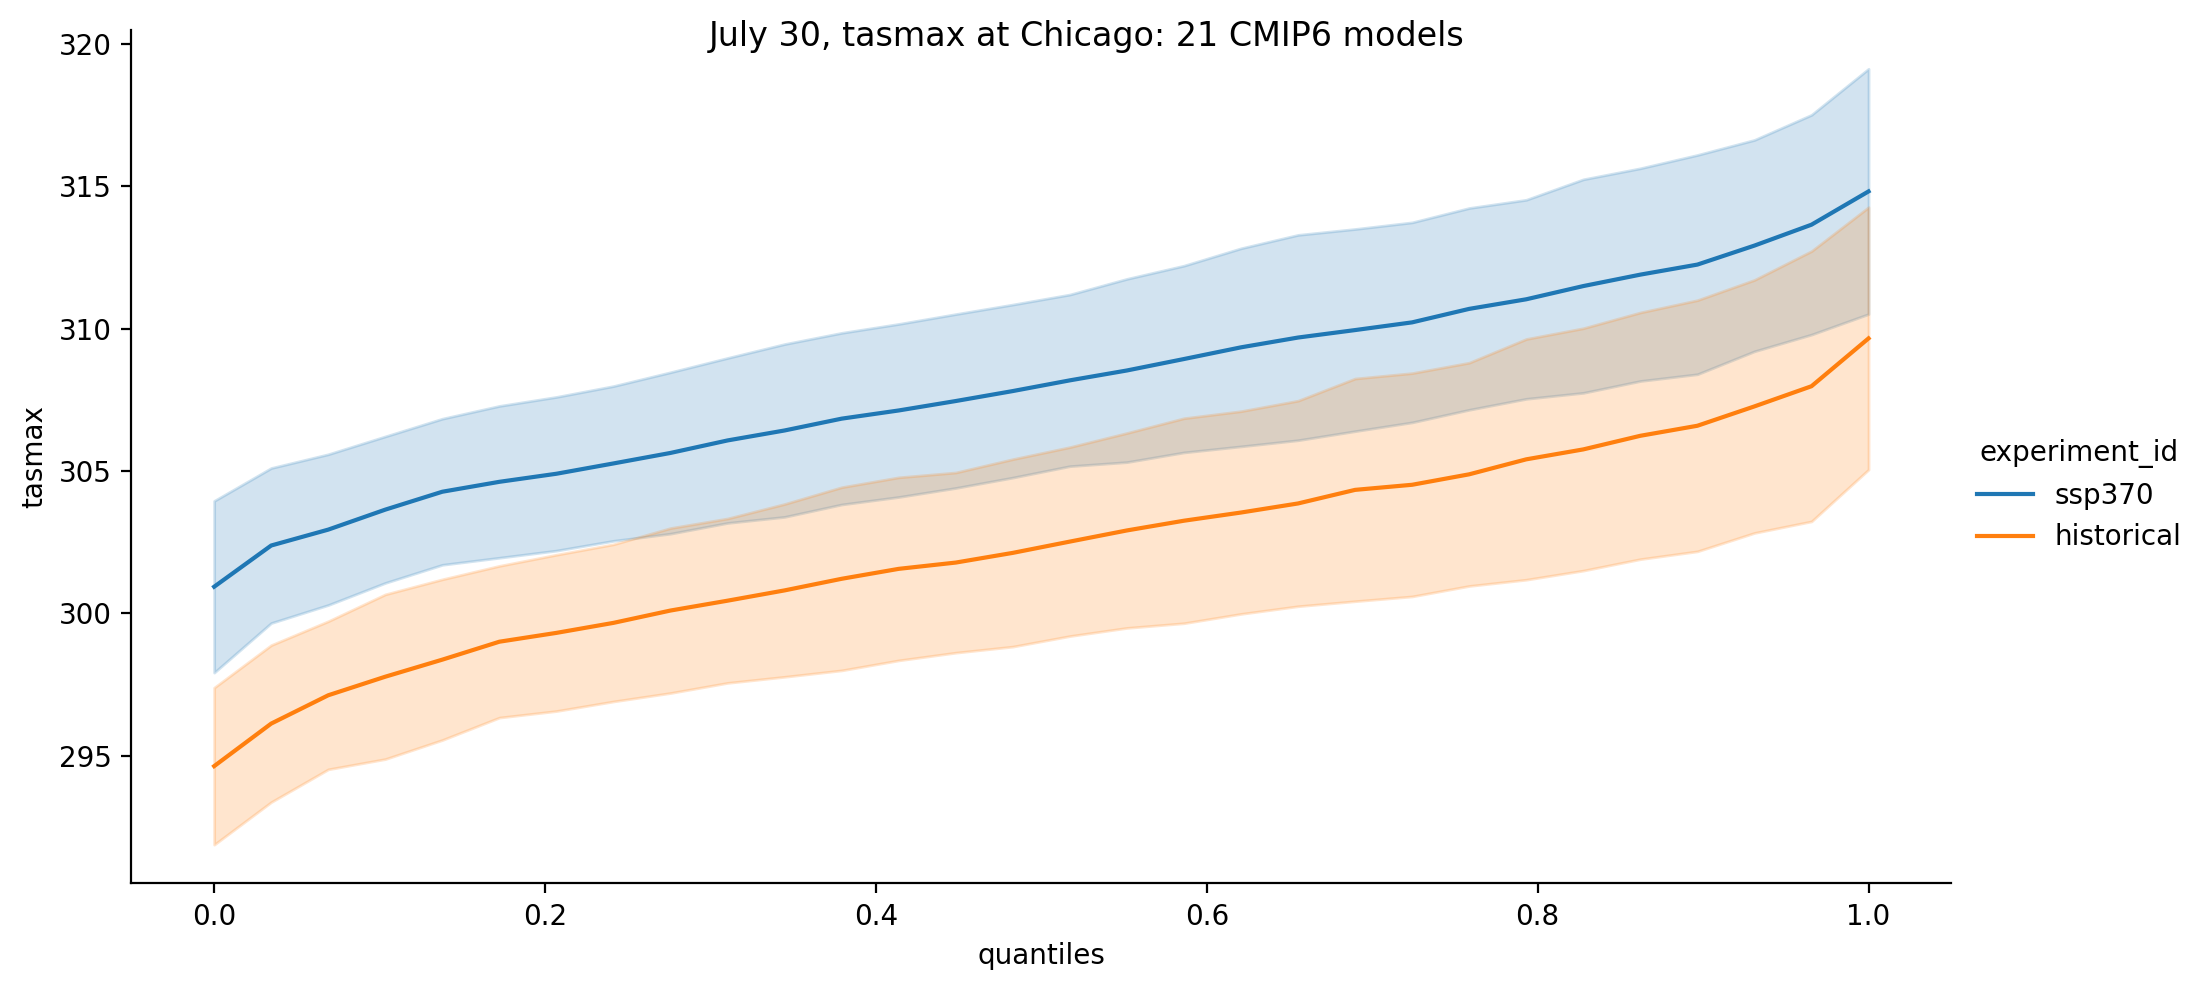

In [61]:
g = sns.relplot(data=df_quants,x="quantiles", y="tasmax",hue='experiment_id',
            kind="line", errorbar="sd", aspect=2);
g.fig.suptitle('July 30, tasmax at Chicago: 21 CMIP6 models')

In [66]:
############## Anomalies ###########################

In [68]:
# Pivot the table based on experiment_id
df_pivot = df_quants.pivot_table(index=['source_id', 'quantiles'], columns='experiment_id', values='tasmax')
df_pivot

experiment_id         historical      ssp370
source_id  quantiles                        
ACCESS-CM2 0.000000   295.197510  302.318115
           0.034483   295.982910  302.533447
           0.068966   296.375977  302.625732
           0.103448   297.168213  305.045166
           0.137931   297.739258  305.705078
...                          ...         ...
NorESM2-MM 0.862069   310.514435  314.588593
           0.896552   310.521576  315.282471
           0.931034   310.573761  315.438629
           0.965517   312.378235  315.642670
           1.000000   313.139221  318.753815

[630 rows x 2 columns]

In [70]:
# Calculate the difference
df_pivot['tasmax_ano'] = df_pivot['ssp370'] - df_pivot['historical']
df_pivot
# Reset the index to turn multi-index back to columns
df_quant_ano = df_pivot.reset_index()[['source_id', 'quantiles', 'tasmax_ano']]
df_quant_ano

experiment_id,source_id,quantiles,tasmax_ano
0,ACCESS-CM2,0.000000,7.120605
1,ACCESS-CM2,0.034483,6.550537
2,ACCESS-CM2,0.068966,6.249756
3,ACCESS-CM2,0.103448,7.876953
4,ACCESS-CM2,0.137931,7.965820
...,...,...,...
625,NorESM2-MM,0.862069,4.074158
626,NorESM2-MM,0.896552,4.760895
627,NorESM2-MM,0.931034,4.864868
628,NorESM2-MM,0.965517,3.264435


Text(0.5, 0.98, 'July 30, tasmax anomaly at Chicago: 21 CMIP6 models')

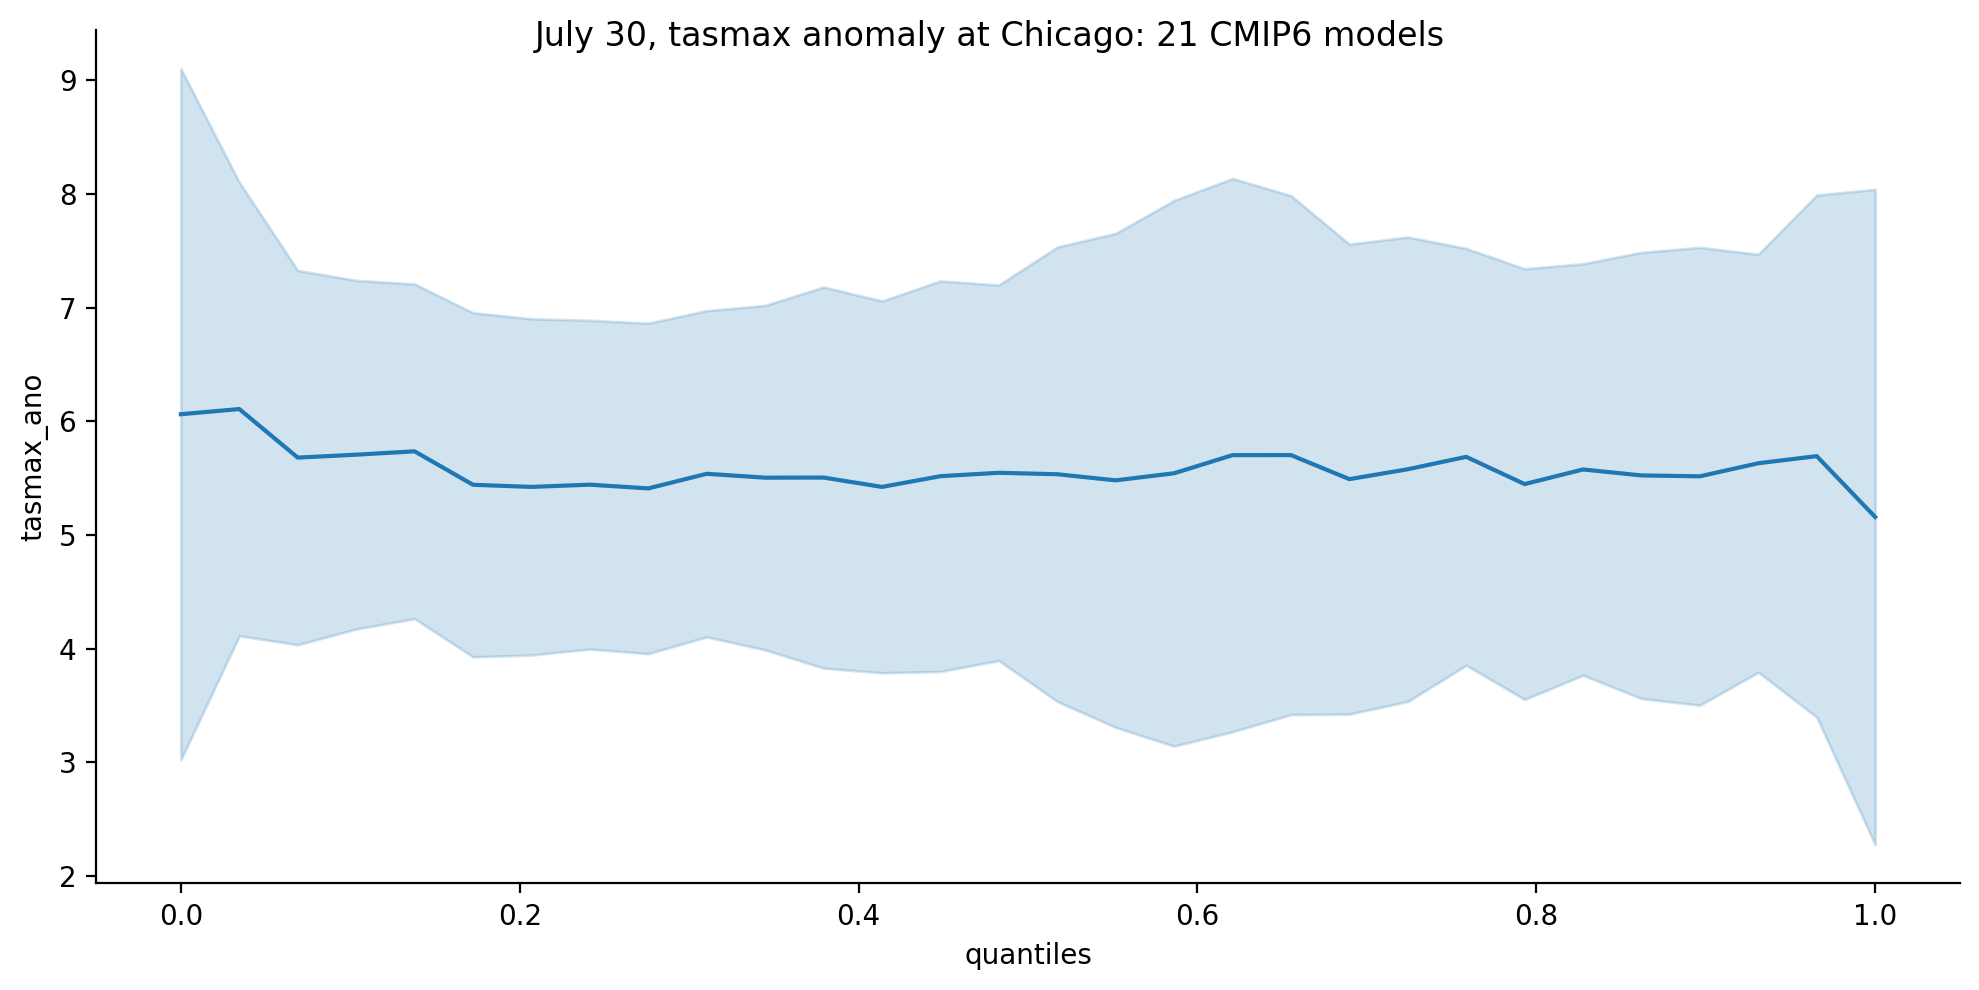

In [73]:
g = sns.relplot(data=df_quant_ano,x="quantiles", y="tasmax_ano",
            kind="line", errorbar="sd", aspect=2);
g.fig.suptitle('July 30, tasmax anomaly at Chicago: 21 CMIP6 models')

In [77]:
# Group by quantiles and compute the standard deviation for Tasmax
df_quantano_std = df_quant_ano.groupby('quantiles')['tasmax_ano'].std().reset_index()

# Rename the column for clarity
df_quantano_std.rename(columns={'tasmax_ano': 'tasmax_sdev'}, inplace=True)
df_quantano_std

,quantiles,tasmax_sdev
0,0.000000,3.039082
1,0.034483,1.994789
2,0.068966,1.646625
3,0.103448,1.533705
4,0.137931,1.472270
5,0.172414,1.514033
6,0.206897,1.479144
7,0.241379,1.446385
8,0.275862,1.453800
9,0.310345,1.435406


Text(0.5, 0.98, 'July 30, tasmax std at Chicago: 21 CMIP6 models')

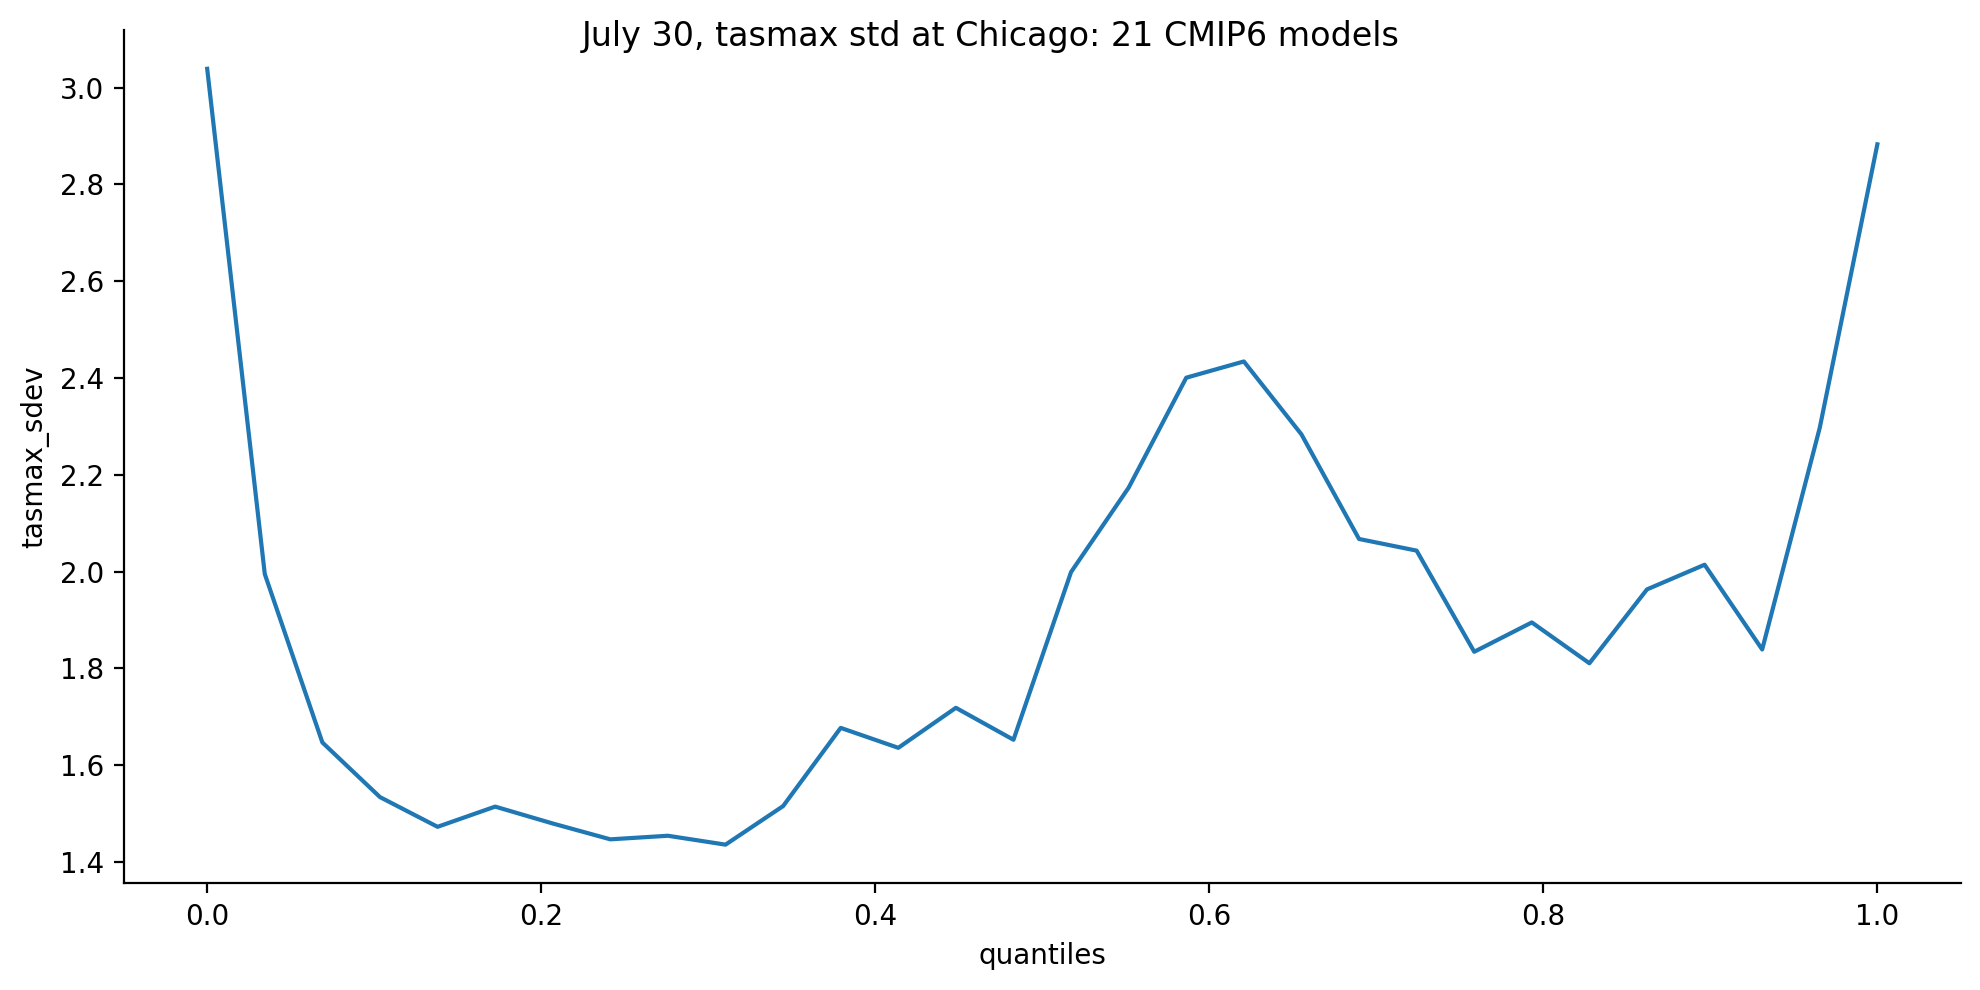

In [78]:
g = sns.relplot(data=df_quantano_std,x="quantiles", y="tasmax_sdev",
            kind="line", errorbar="sd", aspect=2);
g.fig.suptitle('July 30, tasmax std at Chicago: 21 CMIP6 models')